## Sementic Segmentation
- classifier와 비슷한 구조
- encoder로 위치, 공간에 대한 특성유지시킨채로 feature extraction (No FC Layer)
- Decoder를 통해 복원(high resolution restoration)

- 실습내용
    - CT 복원영상에서 폐, 기도, 심장을 가이드하는 모델
    - 데이터 텐서연산
    - U-net 아키텍처
    - Cross-entropy, Dice Loss Funtion, SGDM
    - Dice similarity coefficient 성능지표

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import pandas as pd
import numpy as np

data_dir = '/content/drive/MyDrive/Colab Notebooks/cv_data/Segmentation/'
data_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
data_df.head()

,ImageId,MaskId
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg
2,ID00007637202177411956430_2.jpg,ID00007637202177411956430_mask_2.jpg
3,ID00007637202177411956430_3.jpg,ID00007637202177411956430_mask_3.jpg
4,ID00007637202177411956430_4.jpg,ID00007637202177411956430_mask_4.jpg


In [5]:
def extract_client_id(x):
    return x.split("_")[0]

In [6]:
data_df["Id"] = data_df.ImageId.apply(lambda x:extract_client_id(x))
data_df

,ImageId,MaskId,Id
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg,ID00007637202177411956430
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg,ID00007637202177411956430
2,ID00007637202177411956430_2.jpg,ID00007637202177411956430_mask_2.jpg,ID00007637202177411956430
3,ID00007637202177411956430_3.jpg,ID00007637202177411956430_mask_3.jpg,ID00007637202177411956430
4,ID00007637202177411956430_4.jpg,ID00007637202177411956430_mask_4.jpg,ID00007637202177411956430
...,...,...,...
16703,ID00426637202313170790466_403.jpg,ID00426637202313170790466_mask_403.jpg,ID00426637202313170790466
16704,ID00426637202313170790466_404.jpg,ID00426637202313170790466_mask_404.jpg,ID00426637202313170790466
16705,ID00426637202313170790466_405.jpg,ID00426637202313170790466_mask_405.jpg,ID00426637202313170790466
16706,ID00426637202313170790466_406.jpg,ID00426637202313170790466_mask_406.jpg,ID00426637202313170790466


In [7]:
## client 인원 확인
client_ids = np.unique(data_df.Id.values)
print(len(client_ids))

112


In [8]:
## 환자 1명
index = 0
client_data = data_df[data_df.Id == client_ids[index]][["ImageId", "MaskId"]]

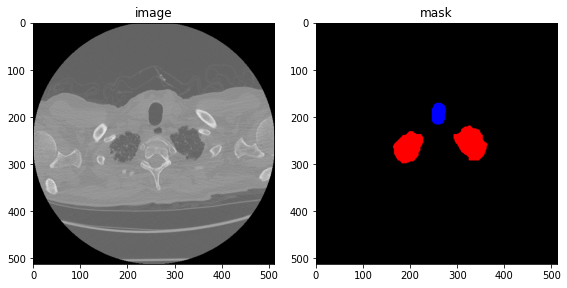

In [9]:
import cv2
import matplotlib.pyplot as plt

sub_index = 2
img_name, mask_name = client_data.iloc[sub_index].values
img_path, mask_path = os.path.join(data_dir, "images", img_name), os.path.join(data_dir, "masks", mask_name)
image = cv2.imread(img_path)
mask = cv2.imread(mask_path)
thres = 240
mask[mask < thres] = 0
mask[mask >= thres] = 255

plt.figure(figsize=(8,6))
plt.subplot(121)
plt.title("image")
plt.imshow(image)
plt.subplot(122)
plt.title("mask")
plt.imshow(mask)
plt.tight_layout()

In [10]:
mask.shape
## 0 : 폐, 1 : 심장, 2 : 기도
mask[...,1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [11]:
def get_client_data(data_df, index):
    client_ids = np.unique(data_df.Id.values)
    client_id = client_ids[index]
    client_data = data_df[data_df.Id == client_id]
    image_files = list(client_data["ImageId"])
    mask_files = list(client_data["MaskId"])
    return client_id, image_files, mask_files

In [12]:
regions = ["background", "trachea", "heart", "lung"]
colors = ((0,0,0), (255, 0, 0), (0, 255, 0), (0, 0, 255))

In [13]:
canvas = np.zeros(shape=(512, 2*512+50, 3), dtype=np.uint8)
canvas.shape

(512, 1074, 3)

In [14]:
# ## image 영상으로재생

# index = 0
# client_id, image_files, mask_files = get_client_data(data_df, index)

# canvas = np.zeros(shape=(512, 2*512+50, 3), dtype=np.uint8)
# for i in range(len(image_files)):
#     image = cv2.imread(os.path.join(data_dir, "images", image_files[i]))
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     mask = cv2.imread(os.path.join(data_dir, "masks", mask_files[i]))
#     mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
#     thres = 240
#     mask[mask < thres] = 0
#     mask[mask >= thres] = 255
#     grid_pad = 50
    
#     canvas[:, :512, :] = image
#     canvas[:, 512+grid_pad:2*512+grid_pad, :] = mask
    
#     text_buff = 410
#     for j in range(1, len(regions)):
#         cv2.putText(canvas, f'{regions[j].upper()}', (900, text_buff), cv2.FONT_HERSHEY_SIMPLEX, 1, colors[j], 2)
#         text_buff += 40
    
#     cv2.imshow('CT frames', canvas)
#     key = cv2.waitKey(60)
#     if key == 27:
#         break
# cv2.destroyAllWindows()

### 데이터셋 준비

In [15]:
IMAGE_SIZE = 224

In [32]:
import torch

class CT_dataset():
    def __init__(self, data_dir, phase, transformer=None):
        self.phase = phase
        self.image_dir = os.path.join(data_dir, phase, 'images')
        self.mask_dir = os.path.join(data_dir, phase, 'masks')        
        self.image_files = [filename for filename in os.listdir(self.image_dir) if filename.endswith('jpg')]
        self.mask_files = [filename for filename in os.listdir(self.mask_dir) if filename.endswith('jpg')]
        assert len(self.image_files) == len(self.mask_files)

        self.transformer = transformer

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image = cv2.imread(os.path.join(self.image_dir, self.image_files[index]))
        image = cv2.resize(image, dsize=(IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_LINEAR)
        mask = cv2.imread(os.path.join(self.mask_dir, self.mask_files[index]))
        mask = cv2.resize(mask, dsize=(IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_LINEAR)

        # mask는 linear로 하면 안되고 비선형적으로 해야함
        # resize, interpolate를 하면, 마스크 값 외에 보간법으로 채워진 다른 값이 들어가게 된다
        # 이 경우, segmentation 수행에 있어, 없던 값을 분류하게 되어 학습이 되지 않을 수 있다.
        # 따라서 마스크는 nearlist로 0 또는 10 등의 값으로 fix될 수 있게 변환해야한다
        mask[mask < 240] = 0
        mask[mask >= 240] = 255
        mask = mask / 255.

        mask_H, mask_W, mask_C = mask.shape
        background = np.ones(shape=(mask_H, mask_W))
        background[mask[...,0] != 0] = 0
        background[mask[...,1] != 0] = 0
        background[mask[...,2] != 0] = 0
        mask = np.concatenate([np.expand_dims(background, -1), mask], axis=-1)
        mask = np.argmax(mask, axis=-1)#, keepdims=False)

        if self.transformer:
            image = self.transformer(image)

        # pixel 단위로 classifier 하므로 integer값으로 변환 및 토치변환    
        target = torch.from_numpy(mask).long()
        return image, target

In [33]:
from torchvision import transforms

def build_transformer():
    transformer = transforms.Compose([
        ## 0과 1사이 분포로 변경
        transforms.ToTensor(),
        ## Normalize
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return transformer

In [34]:
## batch 형태로 이미지가 구성될때, 각 이미지와 라벨을 어떤 형태의 mini batch로 만드는지
def collate_fn(batch):
    images = []
    targets = []
    for a, b in batch:
        images.append(a)
        targets.append(b)
    images = torch.stack(images, dim=0)
    targets = torch.stack(targets, dim=0)

    return images, targets

In [35]:
from torch.utils.data import DataLoader

data_dir = '/content/drive/MyDrive/Colab Notebooks/cv_data/Segmentation/'
transformer = build_transformer()

tr_dataset = CT_dataset(data_dir=data_dir, phase='train', transformer=transformer)
val_dataset = CT_dataset(data_dir=data_dir, phase='val', transformer=transformer)
tr_dataloader = DataLoader(tr_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(tr_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

## datasets 확인
image,target = tr_dataset[3]
print(image.shape)
print(target.shape)

## dataloader 확인
for index, batch in enumerate(tr_dataloader):
    images = batch[0]
    targets = batch[1]
    print(images.shape)
    print(targets.shape)
    break

torch.Size([3, 224, 224])
torch.Size([224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 224, 224])


In [36]:
## dataloader 기능 종합
def build_dataloader(data_dir, batch_size=4):
    transformer = build_transformer()
    
    dataloaders = {}
    train_dataset = CT_dataset(data_dir=data_dir, phase="train", transformer=transformer)
    dataloaders['train'] = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    val_dataset = CT_dataset(data_dir=data_dir, phase="val", transformer=transformer)
    dataloaders['val'] = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
    return dataloaders

In [37]:
dataloaders = build_dataloader(data_dir=data_dir)

for phase in ['train', 'val']:
    for index, batch in enumerate(dataloaders[phase]):
        images = batch[0]
        targets = batch[1]
        print(f"images shape: {images.shape}")
        print(f"masks shape: {targets.shape}")
        if index == 0:
            break

images shape: torch.Size([4, 3, 224, 224])
masks shape: torch.Size([4, 224, 224])
images shape: torch.Size([1, 3, 224, 224])
masks shape: torch.Size([1, 224, 224])


## U-net 구현
-  https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5
- encoder -> Resolution(해상도)는 낮아지고 Semntic(의미론적 feature)는 커진다 / decoder는 반대(- 사진의 크기가 작아지면서 feautre dim은 커진다)
---
- conv layer
- max pooling layer
- up-conv layer
- copy and crop layer

In [38]:
import torch.nn as nn

In [39]:
## conv layer
## conv 2번 통과
def ConvLayer(in_channels, out_channels):
    layers = nn.Sequential(
        ## 링크에 있는 구조와는 조금 다름 : 정보 소실을 줄이기 위해 padding 추가함
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )
    return layers

In [40]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = ConvLayer(in_channels=3, out_channels=64)
        self.conv_block2 = ConvLayer(in_channels=64, out_channels=128)
        self.conv_block3 = ConvLayer(in_channels=128, out_channels=256)
        self.conv_block4 = ConvLayer(in_channels=256, out_channels=512)
        self.conv_block5 = ConvLayer(in_channels=512, out_channels=1024)
        self.pool = nn.MaxPool2d(kernel_size=2)
    
    def forward(self, x):
        ## cooy and crop을 위해 각 층의 값을 가져와야함
        encode_features = []
        
        out = self.conv_block1(x)
        encode_features.append(out)
        out = self.pool(out)

        out = self.conv_block2(out)
        encode_features.append(out)
        out = self.pool(out)

        out = self.conv_block3(out)
        encode_features.append(out)
        out = self.pool(out)

        out = self.conv_block4(out)
        encode_features.append(out)
        out = self.pool(out)

        ## 마지막층은 copy & crop 없음
        out = self.conv_block5(out)        
        return out, encode_features

In [41]:
## 작동 확인
encoder = Encoder()
x = torch.randn(1,3,224,224)    # batch 1, 3*224*224 예시
out, ftrs = encoder(x)

## 계층 확인
print('encoder feature shape')
for ftr in ftrs:
    print(ftr.shape)
print('output size')
print(out.shape)

encoder feature shape
torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 112, 112])
torch.Size([1, 256, 56, 56])
torch.Size([1, 512, 28, 28])
output size
torch.Size([1, 1024, 14, 14])


In [42]:
def UpConvLayer(in_channels, out_channels):
    layers = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    return layers

In [43]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.upconv_layer1 = UpConvLayer(in_channels=1024, out_channels=512)
        self.conv_block1 = ConvLayer(in_channels=512+512, out_channels=512)

        self.upconv_layer2 = UpConvLayer(in_channels=512, out_channels=256)
        self.conv_block2 = ConvLayer(in_channels=256+256, out_channels=256)

        self.upconv_layer3 = UpConvLayer(in_channels=256, out_channels=128)
        self.conv_block3 = ConvLayer(in_channels=128+128, out_channels=128)

        self.upconv_layer4 = UpConvLayer(in_channels=128, out_channels=64)
        self.conv_block4 = ConvLayer(in_channels=64+64, out_channels=64)

    def forward(self, x, encoder_features):
        out = self.upconv_layer1(x)
        croped_enc_feature = self._center_crop(encoder_features[-1], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block1(out)

        out = self.upconv_layer2(out)
        croped_enc_feature = self._center_crop(encoder_features[-2], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block2(out)

        out = self.upconv_layer3(out)
        croped_enc_feature = self._center_crop(encoder_features[-3], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block3(out)

        out = self.upconv_layer4(out)
        croped_enc_feature = self._center_crop(encoder_features[-4], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block4(out)
        return out

    def _center_crop(self, encoder_feature, decoder_feature_size):
        croped_features = transforms.CenterCrop(size=decoder_feature_size)(encoder_feature)
        return croped_features

In [44]:
encoder = Encoder()
decoder = Decoder()
x = torch.randn(1, 3, 224, 224)
out, ftrs = encoder(x)
out = decoder(out, ftrs)

In [45]:
print(out.shape)

torch.Size([1, 64, 224, 224])


In [46]:
import torch.nn.functional as F

In [47]:
class UNet(nn.Module):
    def __init__(self, num_classes, retain_input_dim=True):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        ## 1*1 Conv layer
        self.head = nn.Conv2d(64, num_classes, kernel_size=1)
        self.retain_input_dim = retain_input_dim

    def forward(self, x):
        out, encode_features = self.encoder(x)
        out = self.decoder(out, encode_features)
        out = self.head(out)
        if self.retain_input_dim:
            _, _, H, W = x.shape
            out = F.interpolate(out, size=(H,W))
        return out

In [48]:
model = UNet(num_classes=4)
x = torch.randn(1, 3, 224, 224)
out = model(x)
print(f"input shape: {x.shape}")
print(f"output shape: {out.shape}")

input shape: torch.Size([1, 3, 224, 224])
output shape: torch.Size([1, 4, 224, 224])


## Loss function 구현(Dice Loss)

In [51]:
images.shape

torch.Size([3, 224, 224])

In [69]:
for index, batch in enumerate(tr_dataloader):
  images = batch[0]
  targets = batch[1]
  predictions = model(images)

  if index==0:
    break

In [70]:
num_classes = 4

predictions_ = torch.argmax(predictions, dim=1)
onehot_pred = F.one_hot(predictions_, num_classes=num_classes).permute(0, 3, 1, 2)
onehot_target = F.one_hot(targets, num_classes=num_classes).permute(0, 3, 1, 2)

In [71]:
onehot_pred_ = onehot_pred[0]
onehot_target_ = onehot_target[0]

dice_coeff = 0
for class_index in range(1, num_classes):
  a = onehot_pred_[class_index]
  b = onehot_target_[class_index]
  set_inter = torch.dot(a.reshape(-1).float(), b.reshape(-1).float())
  set_sum = a.sum() + b.sum()
  dice_coeff += (2 * set_inter) / (set_sum + 1e-9)
dice_coeff /= (num_classes-1)

In [72]:
dice_loss = 1. - dice_coeff

In [79]:
## dice loss 구현
class UNet_metric():
  def __init__(self, num_classes):
      self.num_classes = num_classes

  def __call__(self, pred, target):
      onehot_pred = F.one_hot(torch.argmax(pred, dim=1), num_classes=self.num_classes).permute(0, 3, 1, 2)
      onehot_target = F.one_hot(target, num_classes=self.num_classes).permute(0, 3, 1, 2)
      dice_loss = self._get_dice_loss(onehot_pred, onehot_target)
      dice_coefficient = self._get_batch_dice_coefficient(onehot_pred, onehot_target)
      return dice_loss, dice_coefficient

  def _get_dice_coeffient(self, pred, target):
      set_inter = torch.dot(pred.reshape(-1).float(), target.reshape(-1).float())
      set_sum = pred.sum() + target.sum()
      if set_sum.item() == 0:
          set_sum = 2 * set_inter
      dice_coeff = (2 * set_inter) / (set_sum + 1e-9)
      return dice_coeff

  def _get_multiclass_dice_coefficient(self, pred, target):
      dice = 0
      for class_index in range(1, self.num_classes):
          dice += self._get_dice_coeffient(pred[class_index], target[class_index])
      return dice / (self.num_classes - 1)


  def _get_batch_dice_coefficient(self, pred, target):
      num_batch = pred.shape[0]
      dice = 0
      for batch_index in range(num_batch):
          dice += self._get_multiclass_dice_coefficient(pred[batch_index], target[batch_index])
      return dice / num_batch

  def _get_dice_loss(self, pred, target):
      return 1 - self._get_batch_dice_coefficient(pred, target)

In [80]:
criterion = UNet_metric(num_classes=4)
criterion(predictions, targets)

(tensor(0.9185), tensor(0.0815))

In [81]:
## SGDM 최적화 적용
class UNet_metric():
  def __init__(self, num_classes):
      self.num_classes = num_classes
      self.CE_loss = nn.CrossEntropyLoss(reduction='mean')

  def __call__(self, pred, target):
      loss1 = self.CE_loss(pred, target)
      onehot_pred = F.one_hot(torch.argmax(pred, dim=1), num_classes=self.num_classes).permute(0, 3, 1, 2)
      onehot_target = F.one_hot(target, num_classes=self.num_classes).permute(0, 3, 1, 2)
      loss2 = self._get_dice_loss(onehot_pred, onehot_target)
      loss = loss1 + loss2

      dice_coefficient = self._get_batch_dice_coefficient(onehot_pred, onehot_target)
      return loss, dice_coefficient

  def _get_dice_coeffient(self, pred, target):
      set_inter = torch.dot(pred.reshape(-1).float(), target.reshape(-1).float())
      set_sum = pred.sum() + target.sum()
      if set_sum.item() == 0:
          set_sum = 2 * set_inter
      dice_coeff = (2 * set_inter) / (set_sum + 1e-9)
      return dice_coeff

  def _get_multiclass_dice_coefficient(self, pred, target):
      dice = 0
      for class_index in range(1, self.num_classes):
          dice += self._get_dice_coeffient(pred[class_index], target[class_index])
      return dice / (self.num_classes - 1)


  def _get_batch_dice_coefficient(self, pred, target):
      num_batch = pred.shape[0]
      dice = 0
      for batch_index in range(num_batch):
          dice += self._get_multiclass_dice_coefficient(pred[batch_index], target[batch_index])
      return dice / num_batch

  def _get_dice_loss(self, pred, target):
      return 1 - self._get_batch_dice_coefficient(pred, target)

In [82]:
criterion = UNet_metric(num_classes=4)
criterion(predictions, targets)

(tensor(2.2293, grad_fn=<AddBackward0>), tensor(0.0815))

In [83]:
optimizer = torch.optim.SGD(model.parameters(), lr= 1E-3, momentum=0.9)

In [85]:
for index, batch in enumerate(tr_dataloader):
    images = batch[0]
    targets = batch[1]
    predictions = model(images)
    print(criterion(predictions, targets))

    if index == 1:
      break

(tensor(2.2743, grad_fn=<AddBackward0>), tensor(0.0108))
(tensor(2.2565, grad_fn=<AddBackward0>), tensor(0.0964))


## train

In [100]:
from tqdm import tqdm
def train_one_epoch(dataloaders, model, optimizer, criterion, device):
  losses = {}
  dice_coefficients = {}

  for phase in ['train','val']:
    running_loss = 0.0
    running_dice_coeff = 0.0

    if phase == 'train':
        model.train()
    else:
        model.eval()

    for index, batch in tqdm(enumerate(dataloaders[phase])):
        images = batch[0].to(device)
        targets = batch[1].to(device)

        with torch.set_grad_enabled(phase == 'train'):
            predictions = model(images)
            loss, dice_coefficient = criterion(predictions, targets)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        running_loss += loss.item()
        running_dice_coeff += dice_coefficient.item()

        if phase == 'train':
            if index % 100 == 0:
                text = f"{index}/{len(dataloaders[phase])}" + \
                        f" - Running Loss: {loss.item():.4f}" + \
                        f" - Running Dice: {dice_coefficient.item():.4f}" 
                print(text)

    losses[phase] = running_loss / len(dataloaders[phase])
    dice_coefficient[phase] = running_dice_coeff / len(dataloaders[phase])
  return losses, dice_coefficient

In [97]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/cv_data/Segmentation/'
is_cuda = True

NUM_CLASSES = 4
IMAGE_SIZE = 224
BATCH_SIZE = 12
DEVICE = torch.device('cuda' if torch.cuda.is_available and is_cuda else 'cpu')

dataloaders = build_dataloader(data_dir, batch_size=BATCH_SIZE)
model = UNet(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
criterion = UNet_metric(num_classes=NUM_CLASSES)
optimizer = torch.optim.SGD(model.parameters(), lr= 1E-3, momentum=0.9)

In [ ]:
num_epochs = 2

best_epoch = 0
best_score = 0.0
train_loss, train_dice_coefficient = [], []
val_loss, val_dice_coefficient = [], []

for epoch in tqdm(range(num_epochs)):
  losses, dice_coefficients = train_one_epoch(dataloaders, model, optimizer, criterion, DEVICE)
  train_loss.append(losses['train'])
  val_loss.append(losses['val'])
  train_dice_coefficient.append(dice_coefficients['train'])
  val_dice_coefficient.append(dice_coefficients['val'])


  print(f"{epoch}/{num_epochs} - Train Loss: {losses['train']:.4f}, Val Loss: {losses['val']:.4f}")
  print(f"{epoch}/{num_epochs} - Train Dice Coeff: {dice_coefficients['train']:.4f}, Val Dice Coeff: {dice_coefficients['val']:.4f}")
    
  if (epoch > 3) and (dice_coefficients["val"] > best_score):
    best_epoch = epoch
    best_score = dice_coefficients["val"]
    torch.save(model.state_dict(), f"model_{epoch:02d}.pth")

print(f"Best epoch: {best_epoch} -> Best Dice Coeffient: {best_score:.4f}")

  0%|          | 0/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:05,  5.80s/it]

0/1243 - Running Loss: 1.4151 - Running Dice: 0.0000



2it [00:11,  5.93s/it]
3it [00:16,  5.51s/it]
4it [00:23,  6.00s/it]
5it [00:29,  5.84s/it]
6it [00:34,  5.67s/it]
7it [00:40,  5.62s/it]
8it [00:45,  5.46s/it]
9it [00:50,  5.52s/it]
10it [00:56,  5.44s/it]
11it [01:01,  5.54s/it]
12it [01:07,  5.57s/it]
13it [01:13,  5.79s/it]
14it [01:19,  5.75s/it]
15it [01:24,  5.62s/it]
16it [01:30,  5.72s/it]
17it [01:36,  5.68s/it]
18it [01:42,  5.81s/it]
19it [01:47,  5.52s/it]
20it [01:53,  5.60s/it]
21it [01:58,  5.65s/it]
22it [02:04,  5.61s/it]
23it [02:09,  5.40s/it]
24it [02:15,  5.61s/it]
25it [02:21,  5.83s/it]
26it [02:27,  5.73s/it]
27it [02:33,  5.83s/it]
28it [02:38,  5.68s/it]
29it [02:44,  5.75s/it]
30it [02:49,  5.62s/it]
31it [02:55,  5.54s/it]
32it [03:00,  5.56s/it]
33it [03:05,  5.43s/it]
34it [03:11,  5.45s/it]
35it [03:17,  5.54s/it]
36it [03:22,  5.46s/it]
37it [03:27,  5.50s/it]
38it [03:33,  5.58s/it]
39it [03:39,  5.58s/it]
40it [03:44,  5.54s/it]
41it [03:49,  5.43s/it]
42it [03:55,  5.56s/it]
43it [04:00,  5.39s/it]

100/1243 - Running Loss: 1.3514 - Running Dice: 0.0000



102it [09:28,  5.66s/it]
103it [09:34,  5.77s/it]
104it [09:40,  5.73s/it]
105it [09:46,  5.73s/it]
106it [09:51,  5.68s/it]
107it [09:57,  5.68s/it]
108it [10:03,  5.83s/it]
109it [10:08,  5.53s/it]
110it [10:13,  5.45s/it]
111it [10:19,  5.47s/it]
112it [10:24,  5.37s/it]
113it [10:29,  5.39s/it]
114it [10:34,  5.22s/it]
115it [10:40,  5.41s/it]
116it [10:45,  5.43s/it]
117it [10:51,  5.37s/it]
118it [10:56,  5.46s/it]
119it [11:02,  5.48s/it]
120it [11:08,  5.64s/it]
121it [11:13,  5.54s/it]
122it [11:19,  5.60s/it]
123it [11:24,  5.57s/it]
124it [11:30,  5.58s/it]
125it [11:35,  5.40s/it]
126it [11:41,  5.45s/it]
127it [11:47,  5.61s/it]
128it [11:52,  5.46s/it]
129it [11:56,  5.17s/it]
130it [12:01,  5.13s/it]
131it [12:07,  5.21s/it]
132it [12:12,  5.19s/it]
133it [12:17,  5.30s/it]
134it [12:23,  5.48s/it]
135it [12:28,  5.42s/it]
136it [12:33,  5.10s/it]
137it [12:38,  5.25s/it]
138it [12:43,  5.16s/it]
139it [12:49,  5.23s/it]
140it [12:54,  5.33s/it]
141it [13:00,  5.47s/it]

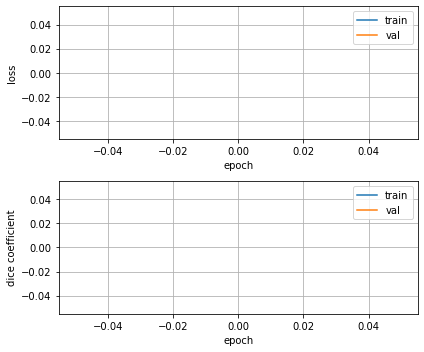

In [102]:
plt.figure(figsize=(6, 5))
plt.subplot(211)
plt.plot(train_loss, label="train")
plt.plot(val_loss,  label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()
plt.subplot(212)
plt.plot(train_dice_coefficient, label="train")
plt.plot(val_dice_coefficient, label="val")
plt.xlabel("epoch")
plt.ylabel("dice coefficient")
plt.grid("on")
plt.legend()
plt.tight_layout()

## model eval, Morphological filtering 적용

In [103]:
def load_model(ckpt_path, num_classes, device):
  checkpoint = torch.load(ckpt_path, map_location=device)
  model = UNet(num_classes=num_classes)
  model.load_state_dict(checkpoint)
  model = model.to(device)
  model.eval()
  return model

In [104]:
is_cuda = True

NUM_CLASSES = 4
IMAGE_SIZE = 224
DEVICE = torch.device('cuda' if torch.cuda.is_available and is_cuda else 'cpu')

In [105]:
ckpt_path = '/content/drive/MyDrive/Colab Notebooks/cv_data/Segmentation/pretrained_model/model_100_epoch.pth'
model = load_model(ckpt_path, NUM_CLASSES, DEVICE)


transformer = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

RuntimeError: ignored

In [106]:
def morpholocal_process(mask, num_classes, ksize=7):
    new_mask = mask.copy()
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(ksize, ksize))

    for class_index in range(1, num_classes):
        binary_mask = (mask == class_index).astype(np.uint8)
        closing = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
        new_mask[closing.astype(np.bool_)] = class_index
    return new_mask

In [108]:
from utils.utils import CLASS_ID_TO_RGB

ModuleNotFoundError: ignored